In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Small_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Large_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Medium_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Small_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Medium_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Medium_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Large_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Medium_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Large_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Large_Trans.csv
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Small_Patterns.txt
/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Small_Trans.csv


In [2]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [3]:
import datetime
import os
from typing import Callable, Optional
import pandas as pd
from sklearn import preprocessing
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from torch_geometric.data import (
    Data,
    InMemoryDataset
)

In [4]:
pd.set_option('display.max_columns', None)
path1 = '/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Medium_Trans.csv'
path2 = '/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Small_Trans.csv'
path3 = '/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Medium_Trans.csv'
path4 = '/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/LI-Small_Trans.csv'
df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)
df3 = pd.read_csv(path3)
df4 = pd.read_csv(path4)

In [5]:
df5 = df1[df1['Is Laundering'] == 1]
df6 = df3[df3['Is Laundering'] == 1]
df7 = df4[df4['Is Laundering'] == 1]

#### **Let's Concatenate the two datasets** 

In [6]:
df = pd.concat([df2, df5, df6, df7], ignore_index=True)

#### **Shuffle the prepared dataset `df` to remove data biasness**

In [7]:
# Import Function shuffle  
from sklearn.utils import shuffle
df = shuffle(df).reset_index(drop=True)

## **Data Visualization**

In [8]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/06 06:22,11296,800FB0580,129974,80BF6BBD0,186.53,US Dollar,186.53,US Dollar,ACH,0
1,2022/09/08 08:30,10,80075F240,1674,800A89660,583.89,US Dollar,583.89,US Dollar,Cheque,0
2,2022/09/02 03:33,29685,8040B3BF0,12979,804F59990,2937.47,US Dollar,2937.47,US Dollar,Cheque,0
3,2022/09/04 23:03,70,1004286A8,16254,802731BE0,787.95,Euro,787.95,Euro,Cheque,0
4,2022/09/10 11:17,1,800BDA3B0,143947,81182E070,173.22,US Dollar,173.22,US Dollar,Credit Card,0


In [9]:
df.dtypes

Timestamp              object
From Bank               int64
Account                object
To Bank                 int64
Account.1              object
Amount Received       float64
Receiving Currency     object
Amount Paid           float64
Payment Currency       object
Payment Format         object
Is Laundering           int64
dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5133181 entries, 0 to 5133180
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 430.8+ MB


In [11]:
df.nunique()

Timestamp              25500
From Bank              38812
Account               532132
To Bank                25527
Account.1             464719
Amount Received       950531
Receiving Currency        15
Amount Paid           959142
Payment Currency          15
Payment Format             7
Is Laundering              2
dtype: int64

#### **Check for Null Values**

In [12]:
df.isnull().sum()

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

#### **Let's check for any difference between `paid amount` and `received amount`**

In [13]:
print("Amount received equals to Amount Paid:")
print(df['Amount Received'].equals(df['Amount Paid']))

Amount received equals to Amount Paid:
False


#### **Let's check whether `Recieving Currency` equals to `Payment Currency`**

In [14]:
print('Receiving Currency equals to Payment Currency:')
print(df['Receiving Currency'].equals(df['Payment Currency']))

Receiving Currency equals to Payment Currency:
False


#### **Let's find out the transactions with `not equal amount` and `not equal currency`**

In [15]:
not_equal_amount = df.loc[~(df['Amount Received'] == df['Amount Paid'])]
not_equal_currency = df.loc[~(df['Receiving Currency'] == df['Payment Currency'])]

print("Total Transactions: ", len(df))
print("Not Equal Amount Transactions Total: ", len(not_equal_amount))
print("Not Equal Currency Transactions Total: ", len(not_equal_currency))

Total Transactions:  5133181
Not Equal Amount Transactions Total:  72158
Not Equal Currency Transactions Total:  72170


In [16]:
filtered_df = df[df['Receiving Currency'] != df['Payment Currency']]
filtered_df

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
117,2022/09/06 18:16,3149,803C0D030,3149,803C0D030,95922165.96,Rupee,1306058.57,US Dollar,ACH,0
128,2022/09/09 23:28,126802,809EAD7D0,126802,809EAD7D0,5001.54,US Dollar,6598.53,Canadian Dollar,ACH,0
173,2022/09/02 12:24,11056,8009D3520,11056,8009D3520,1901.32,US Dollar,1622.59,Euro,ACH,0
175,2022/09/05 12:34,224866,811128C90,224866,811128C90,1263193.58,Rupee,17199.41,US Dollar,ACH,0
206,2022/09/06 11:02,11056,8009D39B0,11056,8009D39B0,1235.17,US Dollar,1054.10,Euro,ACH,0
...,...,...,...,...,...,...,...,...,...,...,...
5132730,2022/09/02 23:41,22828,8016BC5B0,22828,8016BC5B0,1267200.78,Rupee,17253.97,US Dollar,ACH,0
5132812,2022/09/07 21:09,20486,80826ACD0,20486,80826ACD0,255.43,Euro,231.72,UK Pound,ACH,0
5132859,2022/09/08 16:41,10,8001CCEC0,10,8001CCEC0,292.47,Yuan,43.67,US Dollar,ACH,0
5132892,2022/09/08 16:13,212818,804A8A480,212818,804A8A480,56897.95,Mexican Peso,197644.28,Rupee,ACH,0


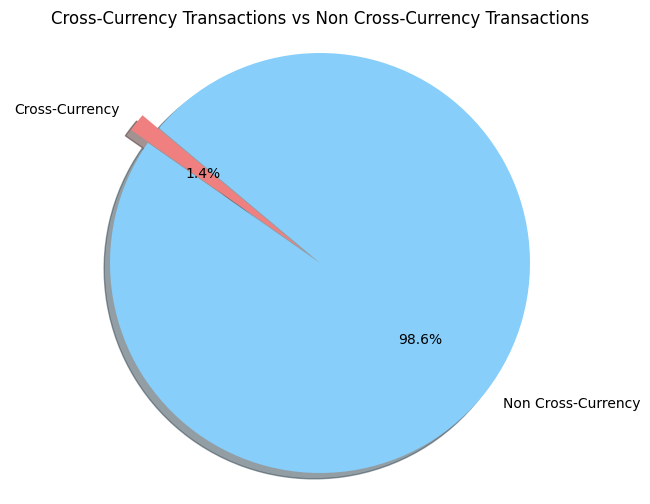

In [17]:
cross_currency_count = len(filtered_df)

total_transactions = len(df)

non_cross_currency_count = total_transactions - cross_currency_count

labels = ['Cross-Currency', 'Non Cross-Currency']
sizes = [cross_currency_count, non_cross_currency_count]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Cross-Currency Transactions vs Non Cross-Currency Transactions')
plt.axis('equal')
plt.show()

#### **Let's find out what are the Different `Currency` Types**

In [18]:
print(sorted(df['Receiving Currency'].unique()))
print(sorted(df['Payment Currency'].unique()))

['Australian Dollar', 'Bitcoin', 'Brazil Real', 'Canadian Dollar', 'Euro', 'Mexican Peso', 'Ruble', 'Rupee', 'Saudi Riyal', 'Shekel', 'Swiss Franc', 'UK Pound', 'US Dollar', 'Yen', 'Yuan']
['Australian Dollar', 'Bitcoin', 'Brazil Real', 'Canadian Dollar', 'Euro', 'Mexican Peso', 'Ruble', 'Rupee', 'Saudi Riyal', 'Shekel', 'Swiss Franc', 'UK Pound', 'US Dollar', 'Yen', 'Yuan']


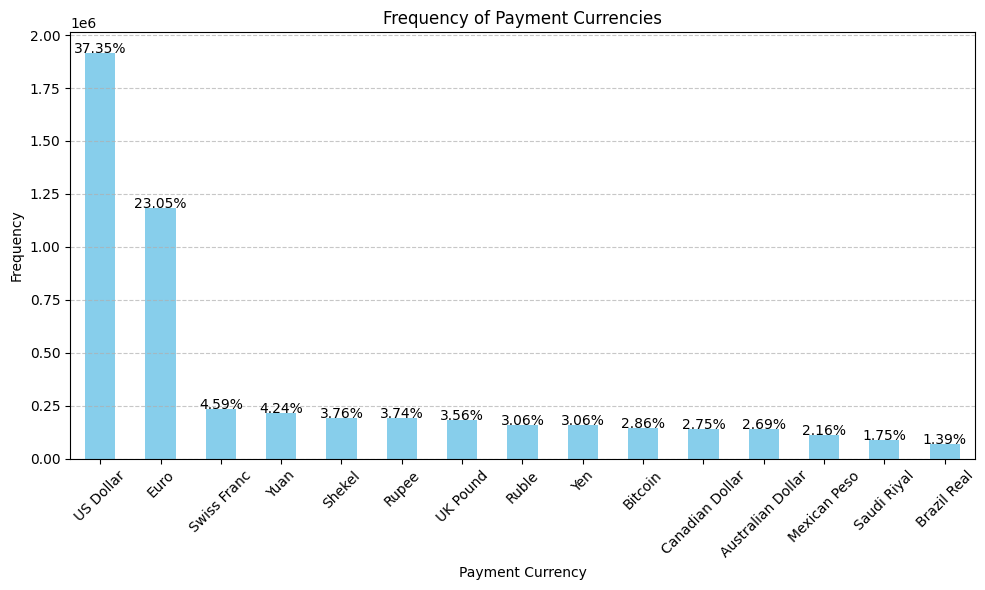

In [19]:
currency_counts = df['Payment Currency'].value_counts()
total_transactions = len(df)
currency_percentage = (currency_counts / total_transactions) * 100

plt.figure(figsize=(10, 6))
bars = currency_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Payment Currencies')
plt.xlabel('Payment Currency')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(currency_counts):
    plt.text(i, v + 0.5, f'{currency_percentage.iloc[i]:.2f}%', ha='center')

plt.tight_layout()
plt.show()

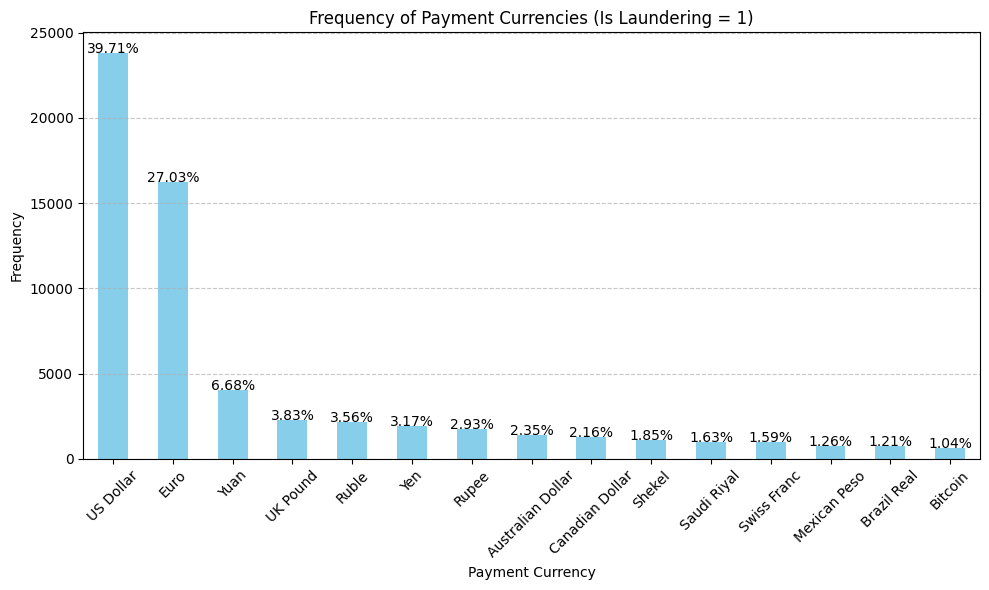

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

laundering_df = df[df['Is Laundering'] == 1]

currency_counts = laundering_df['Payment Currency'].value_counts()

total_transactions = len(laundering_df)
currency_percentage = (currency_counts / total_transactions) * 100

plt.figure(figsize=(10, 6))
bars = currency_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Payment Currencies (Is Laundering = 1)')
plt.xlabel('Payment Currency')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(currency_counts):
    plt.text(i, v + 0.5, f'{currency_percentage.iloc[i]:.2f}%', ha='center')

plt.tight_layout()
plt.show()

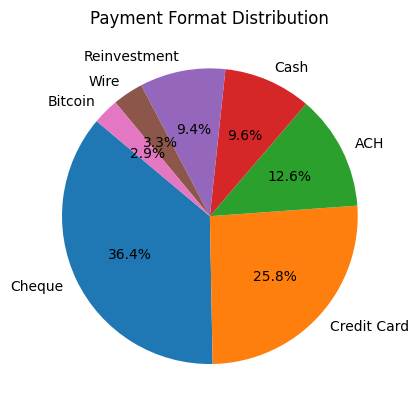

In [21]:
plt.pie(df['Payment Format'].value_counts(), labels=df['Payment Format'].value_counts().index, autopct='%1.1f%%', startangle=140)

plt.title('Payment Format Distribution')

plt.show()

#### **Check the number of transactions from each bank**

In [22]:
df['From Bank'].value_counts()

From Bank
70         458998
10          81670
12          80067
1           62414
15          52627
            ...  
353322          1
1177924         1
347769          1
159140          1
335907          1
Name: count, Length: 38812, dtype: int64

There are 1,23,511 different banks data are available here from where money is send.

In [23]:
df['To Bank'].value_counts()

To Bank
10         42615
12         42165
15         38813
220        30654
1          30289
           ...  
2116034        1
1171528        1
315410         1
148984         1
269329         1
Name: count, Length: 25527, dtype: int64

There are 65,915 different banks are available here to where money is send.

#### **Describe the From and To accounts**

In [ ]:
df[['Account', 'Account.1']].describe()

#### **Total counts of Laundering values**

In [24]:
df['Is Laundering'].value_counts()

Is Laundering
0    5073168
1      60013
Name: count, dtype: int64

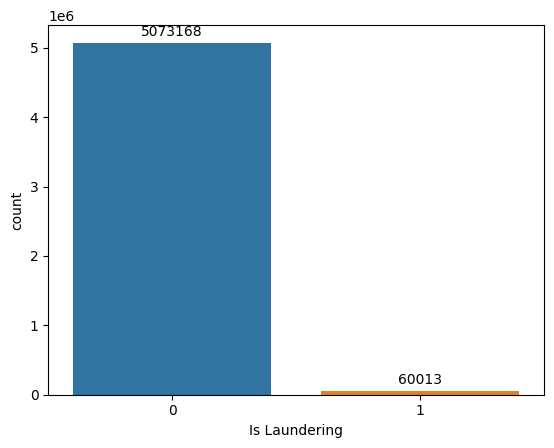

In [25]:
# Create the count plot
ax = sns.countplot(data=df, x='Is Laundering')

# Add count numbers on the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'baseline', 
                xytext = (0, 5), 
                textcoords = 'offset points')

# Show the plot
plt.show()

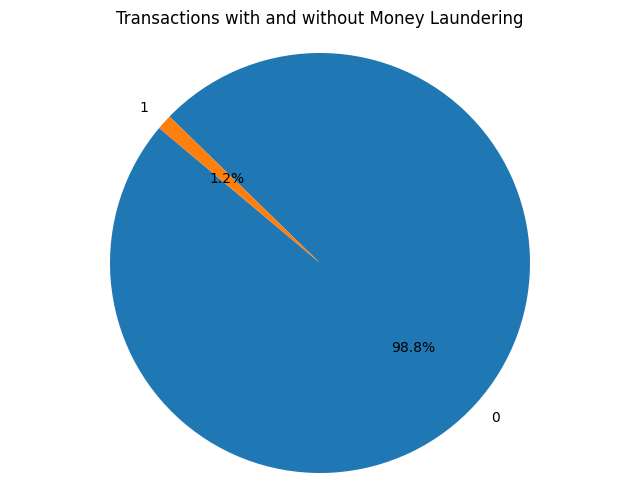

In [26]:
import matplotlib.pyplot as plt

laundering_counts = df['Is Laundering'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(laundering_counts, labels=laundering_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Transactions with and without Money Laundering')
plt.axis('equal')
plt.show()

In [27]:
laundering_df.shape

(60013, 11)

In [28]:
print("This is the total number of laundering transactions in different currencies:\n",currency_counts)

This is the total number of laundering transactions in different currencies:
 Payment Currency
US Dollar            23829
Euro                 16219
Yuan                  4007
UK Pound              2297
Ruble                 2138
Yen                   1905
Rupee                 1756
Australian Dollar     1408
Canadian Dollar       1297
Shekel                1111
Saudi Riyal            980
Swiss Franc            954
Mexican Peso           759
Brazil Real            726
Bitcoin                627
Name: count, dtype: int64


/tmp/ipykernel_975/3022132148.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  money_laundering_df['Timestamp'] = pd.to_datetime(money_laundering_df['Timestamp'])
/tmp/ipykernel_975/3022132148.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  money_laundering_df['Day'] = money_laundering_df['Timestamp'].dt.day


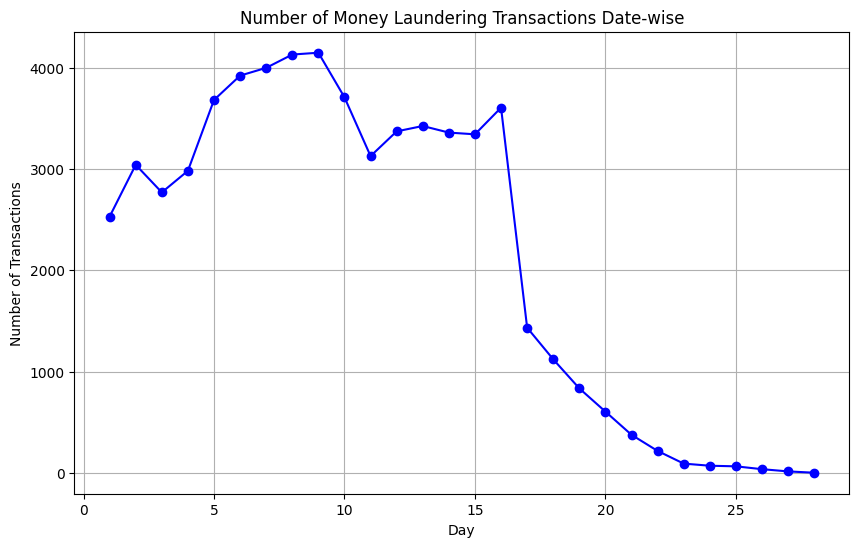

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing transaction data

# Step 1: Filter money laundering data
money_laundering_df = df[df['Is Laundering'] == 1]

# Step 2: Convert Timestamp column to datetime
money_laundering_df['Timestamp'] = pd.to_datetime(money_laundering_df['Timestamp'])

# Step 3: Extract year from Timestamp
money_laundering_df['Day'] = money_laundering_df['Timestamp'].dt.day

# Step 4: Count number of transactions for each year
transactions_by_year = money_laundering_df.groupby('Day').size()

# Step 5: Visualize the number of transactions year-wise
transactions_by_year.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Number of Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

### **Check for Outliers** 

An outlier is data that deviates extremely (far) from the average of a dataset. In practice, outliers usually need to be treated specially. Generally, there are two common ways to handle outliers: either by removing them or by replacing them with the mean/average/mode of the dataset. First, let's identify which data points are recognized as outliers.

One method to identify and gather outliers is by searching for data that is either smaller than the mean minus (3 standard deviations) or larger than the mean plus (3 standard deviations). The method below can identify whether a transaction has an outlier value in the 'Amount Received' column or not.

In [30]:
#Identification of Outlier Values
mean = df['Amount Received'].mean()
std = df['Amount Received'].std()
Tmin = mean - (3 * std)
Tmax = mean + (3 * std)

# Display values from the 'Amount Received' column that are less than Tmin or greater than Tmax
filtered_values = df[(df['Amount Received'] < Tmin) | (df['Amount Received'] > Tmax)]['Amount Received'].values
print(filtered_values)

[4.02847348e+09 1.25636807e+10 7.57254202e+09 ... 1.06552402e+10
 1.44239218e+10 7.84690477e+09]


In [31]:
# Viewing the number of data points identified by filtered_values
number_of_identified_data_points = len(filtered_values)
print("Number of data points identified as Outliers:", number_of_identified_data_points)

Number of data points identified as Outliers: 1171


Once we have identified which data points are outliers, the next step is to decide on the special treatment for these outliers (ignore/remove/manipulate). We deliberately chose not to immediately remove the outlier values because we suspect that money laundering perpetrators might receive amounts from source accounts that are unusual or extremely deviating from the average of most people.

To determine what action is reasonable for outliers in this money laundering case, we need to examine how many of the outliers are identified as money laundering and how many are not identified as money laundering.

In [32]:
# Display data that matches in DataFrame format
outliers_dataframe = df[(df['Amount Received'] < Tmin) | (df['Amount Received'] > Tmax)]

# Display the number of unique values in the 'Is Laundering' column from the DataFrame outliers_dataframe
count_is_laundering = outliers_dataframe['Is Laundering'].value_counts()
print("Count of each unique value in the 'Is Laundering' column:\n", count_is_laundering)

Count of each unique value in the 'Is Laundering' column:
 Is Laundering
0    1114
1      57
Name: count, dtype: int64


In [33]:
df[df['Amount Received'].isin(filtered_values)]

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
1448,2022/09/01 00:01,70,1004287C8,16792,80616E470,4.028473e+09,Ruble,4.028473e+09,Ruble,Cheque,0
2813,2022/09/09 17:21,16,805424040,214749,8055E2C70,1.256368e+10,Rupee,1.256368e+10,Rupee,Cheque,0
3735,2022/09/09 23:46,112637,8053C22F0,71,8059B9B60,7.572542e+09,Rupee,7.572542e+09,Rupee,ACH,0
3746,2022/09/01 10:56,10057,803D96F60,210972,8046EF1A0,1.238089e+10,Yen,1.238089e+10,Yen,Cheque,0
7465,2022/09/01 19:33,28,8064A16D0,28,8064A16D0,7.351936e+09,Ruble,7.351936e+09,Ruble,Reinvestment,0
...,...,...,...,...,...,...,...,...,...,...,...
5115695,2022/09/05 07:12,14433,8024F5C40,24,80402F130,6.378539e+09,Yen,6.378539e+09,Yen,Cheque,0
5123252,2022/09/04 18:19,131503,813FF4130,157141,815253260,3.530590e+09,Yen,3.530590e+09,Yen,ACH,1
5125515,2022/09/06 15:48,22775,801EDC4C0,22775,801EDC4C0,1.065524e+10,Yen,8.627307e+07,Euro,ACH,0
5126541,2022/09/05 02:50,28255,80445C110,28255,80445C110,1.442392e+10,Rupee,1.963935e+08,US Dollar,ACH,0


### **Feature Selection and Manipulation**

As we know, Machine Learning can only process numerical data. Therefore, it is important for us to wisely select the features available. When there are features that cannot be processed, we need to manipulate them to produce meaningful values.

Based on the data information above, there are several columns that are not of numerical data type:

- Timestamp

- Account

- Account.1

- Receiving Currency

- Payment Currency

- Payment Format

In [34]:
# check data atribute
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

We began by manipulating the 'Timestamp' column. The 'Timestamp' column is an object-type column that stores data in the format Year/Month/Day/Hour/Minute of a transaction. We manipulated the 'Timestamp' column by extracting only the hour and minute into new columns named 'Hour' and 'Minutes', both of integer type.

This was done not without reason, as we suspect that money laundering activities may occur at specific times. Therefore, we converted the 'Timestamp' column, which was initially of object type, to a datetime type.

Once the system recognized the 'Timestamp' column as a datetime type, we created new columns ('Hour' and 'Minutes') to store the hour and minute from the 'Timestamp' column. As a result, the 'Timestamp' column became irrelevant, so we decided to drop it.

In [35]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Access hour and minute attributes using 'dt'
df['Hour'] = df['Timestamp'].dt.hour
df['Minutes'] = df['Timestamp'].dt.minute

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5133181 entries, 0 to 5133180
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Timestamp           datetime64[ns]
 1   From Bank           int64         
 2   Account             object        
 3   To Bank             int64         
 4   Account.1           object        
 5   Amount Received     float64       
 6   Receiving Currency  object        
 7   Amount Paid         float64       
 8   Payment Currency    object        
 9   Payment Format      object        
 10  Is Laundering       int64         
 11  Hour                int32         
 12  Minutes             int32         
dtypes: datetime64[ns](1), float64(2), int32(2), int64(3), object(5)
memory usage: 470.0+ MB


In [37]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Hour,Minutes
0,2022-09-06 06:22:00,11296,800FB0580,129974,80BF6BBD0,186.53,US Dollar,186.53,US Dollar,ACH,0,6,22
1,2022-09-08 08:30:00,10,80075F240,1674,800A89660,583.89,US Dollar,583.89,US Dollar,Cheque,0,8,30
2,2022-09-02 03:33:00,29685,8040B3BF0,12979,804F59990,2937.47,US Dollar,2937.47,US Dollar,Cheque,0,3,33
3,2022-09-04 23:03:00,70,1004286A8,16254,802731BE0,787.95,Euro,787.95,Euro,Cheque,0,23,3
4,2022-09-10 11:17:00,1,800BDA3B0,143947,81182E070,173.22,US Dollar,173.22,US Dollar,Credit Card,0,11,17


In [38]:
#Drop unrelatable columns
df = df.drop(columns=['Timestamp'])

After manipulating the 'Timestamp' column, we turned our attention to the next features, 'Account' and 'Account.1', where 'Account' represents the hexadecimal code of the source transaction account, and 'Account.1' represents the hexadecimal code of the destination transaction account. In this process, we want to determine if there is an effect if a transaction is made from an account to the same account concerning the identification of money laundering transactions.

Therefore, we created a new column named 'Different Account', which will have a value of 0 if the transaction is made to the same account as the sender's account, and a value of 1 if the transaction is made to a different account from the sender's account. After creating the 'Different Account' column, the 'Account' and 'Account.1' columns become irrelevant and can be dropped.